# Part I: Basic TN Algebra

In this part, we will practice some basic multilinear algebra to manipulate tensor networks. You require only a working installation of *python* and *numpy*. See *exercise.pdf* for more details.

## Exercise 1: TN to Tensor Conversion

1. Implement a function that converts the TN from Figure 2 to a tensor.

In [1]:
# numpy required
import numpy as np

In [2]:
# the TN from Figure 2 is defined by 4 tensors
def star_to_tensor(A, B, C, O):
    AO   = np.tensordot(A,   O, axes=([1], [0]))
    AOB  = np.tensordot(AO,  B, axes=([1], [1]))
    AOB  = np.transpose(AOB, (0, 2, 1))
    AOBC = np.tensordot(AOB, C, axes=([2], [1]))
    return AOBC

In [3]:
# test if the function works
A = np.random.randn(2, 10)
B = np.random.randn(3, 11)
C = np.random.randn(4, 12)
O = np.random.randn(10, 11, 12)

X = star_to_tensor(A, B, C, O)
print(X.shape)

(2, 3, 4)


2. Implement a function that converts the TN from Figure 3 to a tensor.

In [4]:
# the TN from Figure 3 is defined by 4 tensors
def triangle_to_tensor(A, B, C):
    AB  = np.tensordot(A,  B, axes=([1], [1]))
    ABC = np.tensordot(AB, C, axes=([1, 3], [1, 2]))
    return ABC

In [5]:
# test if the function works
A = np.random.randn(2, 10, 11)
B = np.random.randn(3, 10, 12)
C = np.random.randn(4, 11, 12)

X = triangle_to_tensor(A, B, C)
print(X.shape)

(2, 3, 4)


## Exercise 2: Tensor to TN Conversion

1. Implement a function that converts a tensor to a TN from Figure 2.

In [6]:
# return 4 tensors defining the TN from Figure 2
def tensor_to_star(X):
    dims = X.shape
    assert len(dims) == 3 # only works with order 3 tensors
    
    # A
    M     = np.reshape(X, (dims[0], dims[1]*dims[2]))
    A, R  = np.linalg.qr(M)
    linkA = R.shape[0]
    R     = np.reshape(R, (linkA, dims[1], dims[2]))
    
    # B
    R     = np.transpose(R, (1, 0, 2))
    R     = np.reshape(R, (dims[1], dims[2]*linkA))
    B, R  = np.linalg.qr(R)
    linkB = R.shape[0]
    R     = np.reshape(R, (linkB, linkA, dims[2]))
    
    # C
    R     = np.transpose(R, (2, 0, 1))
    R     = np.reshape(R, (dims[2], linkB*linkA))
    C, R  = np.linalg.qr(R)
    linkC = R.shape[0]
    
    # O
    O     = np.reshape(R, (linkC, linkB, linkA))
    O     = np.transpose(O, (2, 1, 0))
    
    return A, B, C, O

In [7]:
# test if the functions work correctly
X          = np.random.randn(2, 3, 4)
A, B, C, O = tensor_to_star(X)
X_         = star_to_tensor(A, B, C, O)
delta      = X-X_
print(np.linalg.norm(delta)) # this should be numerically 0

1.4038533086086518e-15


2. Implement a function that converts a tensor to a TN from Figure 3.

In [8]:
def tensor_to_triangle(X):
    dims = X.shape
    assert len(dims) == 3 # only works with order 3 tensors
    
    # A
    M    = np.reshape(X, (dims[0], dims[1]*dims[2]))
    A, R = np.linalg.qr(M)
    
    # decide on first rank
    linkA = R.shape[0]
    linkC = 1
    if linkA > 1:
        for i in range(2, linkA+1):
            if linkA % i == 0:
                linkC = linkA//i
                linkA = i
                break
    
    A = np.reshape(A, (dims[0], linkA, linkC))
    R = np.reshape(R, (linkA, linkC, dims[1], dims[2]))
    
    # B
    R     = np.transpose(R, (0, 2, 1, 3))
    R     = np.reshape(R, (linkA*dims[1], dims[2]*linkC))
    B, R  = np.linalg.qr(R)
    linkB = R.shape[0]
    B     = np.reshape(B, (linkA, dims[1], linkB))
    B     = np.transpose(B, (1, 0, 2))
    
    # C
    C     = np.reshape(R, (linkB, linkC, dims[2]))
    C     = np.transpose(C, (2, 1, 0))

    return A, B, C

In [9]:
X       = np.random.randn(2, 3, 4)
A, B, C = tensor_to_triangle(X)
X_      = triangle_to_tensor(A, B, C)
delta   = X-X_
print(np.linalg.norm(delta)) # this should be numerically 0

1.1614359087401131e-15


## Exercise 3: TT Truncation

In [10]:
# convert TT to tensor for later testing
import copy
def tt_to_tensor(tt):
    N      = len(tt)
    tensor = np.copy(tt[0])
    for i in range(1, N):
        core   = tt[i]
        tensor = np.tensordot(tensor, core, axes=1)
    
    return tensor

1. Implement a function that orthogonalizes a TT

In [11]:
# orthogonalize TT
def orthogonalize_tt(tt, center = 0):
    N = len(tt)
    
    assert N > 1
    assert center >= 0
    assert center <= N-1

    ortho_tt = copy.deepcopy(tt)
    
    # left orthogonalize
    if center > 0:
        core        = ortho_tt[0]
        
        assert len(core.shape) == 2
        
        Q, R        = np.linalg.qr(core)
        ortho_tt[0] = Q
        ortho_tt[1] = np.tensordot(R, ortho_tt[1], axes=1)

    for i in range(1, center):
        core = ortho_tt[i]
        
        assert len(core.shape) == 3
        
        link_left  = core.shape[0]
        link_right = core.shape[2]
        site_dim   = core.shape[1]
        
        core          = np.reshape(core, (link_left*site_dim, link_right))
        Q, R          = np.linalg.qr(core)
        ortho_tt[i]   = np.reshape(Q, (link_left, site_dim, link_right))
        ortho_tt[i+1] = np.tensordot(R, ortho_tt[i+1], axes=1)
    
    # right orthogonalize
    if center < N-1:
        core          = ortho_tt[N-1]
        
        assert len(core.shape) == 2
        
        core          = np.transpose(core)
        Q, R          = np.linalg.qr(core)
        Q             = np.transpose(Q)
        ortho_tt[N-1] = Q
        ortho_tt[N-2] = np.tensordot(R, ortho_tt[N-2], axes=([-1], [-1]))
        ortho_tt[N-2] = np.transpose(ortho_tt[N-2], (1, 2, 0))

    for i in range(N-2, center, -1):
        core = ortho_tt[i]
        
        assert len(core.shape) == 3
        
        link_left  = core.shape[0]
        link_right = core.shape[2]
        site_dim   = core.shape[1]
        
        core          = np.transpose(core, (2, 1, 0))
        core          = np.reshape(core, (link_right*site_dim, link_left))
        
        Q, R          = np.linalg.qr(core)
        Q             = np.reshape(Q, (link_right, site_dim, link_left))
        ortho_tt[i]   = np.transpose(Q, (2, 1, 0))
        ortho_tt[i-1] = np.tensordot(R, ortho_tt[i-1], axes=([-1], [-1]))
        
        if i > 1:
            ortho_tt[i-1] = np.transpose(ortho_tt[i-1], (1, 2, 0))
        elif i == 1:
            ortho_tt[0]   = np.transpose(ortho_tt[0])
        
    return ortho_tt

In [12]:
# check if correct
A  = np.random.randn(2, 5)
B  = np.random.randn(5, 3, 4)
C  = np.random.randn(4, 4, 2)
D  = np.random.randn(2, 5)
tt = [A, B, C, D]

# all errors should be numerically 0
for i in range(0,4):
    ortho_tt = orthogonalize_tt(tt, center = i)
    X        = tt_to_tensor(tt)
    X_       = tt_to_tensor(ortho_tt)
    delta    = X-X_
    print(np.linalg.norm(delta))

3.381832093311791e-14
5.380797748524792e-14
3.4940230275287355e-14
3.5293929955033066e-14


2. Implement a function that truncates a TT

In [13]:
# return truncated TT and sum of truncated singular values
def truncate_tt(tt, site, rank):
    N = len(tt)
    
    assert N > 1
    assert site >= 0
    assert site < N-1
    assert rank > 0

    truncated = orthogonalize_tt(tt, center = site)
    core      = truncated[site]
    eps       = 0.
    
    if site > 0:
        assert len(core.shape) == 3
        
        link_left  = core.shape[0]
        link_right = core.shape[2]
        site_dim   = core.shape[1]
        core       = np.reshape(core, (link_left*site_dim, link_right))
        
    U, s, Vh   = np.linalg.svd(core, full_matrices = False)
    link_right = Vh.shape[1]
    
    if rank < len(s):
        eps               = np.sum(np.square(s[rank:]))
        U                 = U[:,0:rank]
        R                 = np.diag(s[0:rank]) @ Vh[0:rank,:]
        truncated[site+1] = np.tensordot(R, truncated[site+1], axes = 1)
        link_right        = rank
    else:
        R                 = np.diag(s) @ Vh
        truncated[site+1] = np.tensordot(R, truncated[site+1], axes = 1)

        
    if site > 0:
        U = np.reshape(U, (link_left, site_dim, link_right))
        
    truncated[site] = U
    
    return truncated, eps

In [14]:
# check if correct
A  = np.random.randn(5, 5)
B  = np.random.randn(5, 5, 10)
C  = np.random.randn(10, 5, 5)
D  = np.random.randn(5, 5)
tt = [A, B, C, D]

# error and singular values should be numerically the same
for i in range(0, 3):
    site           = i
    rank           = 2
    truncated, eps = truncate_tt(tt, site, rank)
    X              = tt_to_tensor(tt)
    X_             = tt_to_tensor(truncated)
    error          = np.tensordot(X-X_, X-X_, axes = 4)
    print("site                   = ", i)
    print("sum of singular values = ", eps)
    print("error                  = ", error)
    print("relative difference    = ", abs(eps-error)/error)
    print("\n------------------------------------------------\n")

site                   =  0
sum of singular values =  24302.462737031907
error                  =  24302.4627370319
relative difference    =  2.9939178152082423e-16

------------------------------------------------

site                   =  1
sum of singular values =  68846.57386343722
error                  =  68846.5738634372
relative difference    =  4.2273462314135676e-16

------------------------------------------------

site                   =  2
sum of singular values =  45270.21372833815
error                  =  45270.213728338174
relative difference    =  4.821685396392662e-16

------------------------------------------------



# Part III: Advanced Applications

## Exercise 5: Higher-Order PCA

In [15]:
import tensap

# choose file to run
file = "C:\\Users\\mazen\\Google Drive\\Research\\Software\\Python\\Anthony\\tensap-v1.1\\tutorials\\approximation\\tutorial_PCA_FunctionalTensorPrincipalComponentAnalysis.py"

%run "$file"

Henon-Heiles
--- Higher order PCA ---
Number of evaluations = 
[25, 25, 25, 25, 25]
Ranks {1, ..., d} = 
[3, 4, 4, 4, 3]

--- Approximation in Tucker format ---

Prescribed ranks
alpha = 2 : rank = 4, nb_eval = 20
alpha = 3 : rank = 1, nb_eval = 5
alpha = 4 : rank = 2, nb_eval = 10
alpha = 5 : rank = 3, nb_eval = 15
alpha = 6 : rank = 4, nb_eval = 20
Interpolation - nb_eval = 96
Number of evaluations = 166
Storage = 166
Prescribed ranks = [4 1 2 3 4]
Ranks = [4 1 2 3 4]
Error = 2.06286e+00

Prescribed tolerance
alpha = 2 : rank = 3, nb_eval = 20
alpha = 3 : rank = 4, nb_eval = 25
alpha = 4 : rank = 4, nb_eval = 25
alpha = 5 : rank = 4, nb_eval = 25
alpha = 6 : rank = 3, nb_eval = 20
Interpolation - nb_eval = 576
Number of evaluations = 691
Ranks = [3 4 4 4 3]
Error = 5.77181e-15

--- Approximation in tree based format ---

Prescribed ranks
alpha = 5 : rank = 5, nb_eval = 800
alpha = 6 : rank = 5, nb_eval = 800
alpha = 7 : rank = 5, nb_eval = 700
alpha = 8 : rank = 4, nb_eval = 400
alph

alpha = 6 : rank = 3, nb_eval = 50
alpha = 4 : rank = 4, nb_eval = 65
alpha = 2 : rank = 4, nb_eval = 65
alpha = 3 : rank = 4, nb_eval = 65
alpha = 7 : rank = 3, nb_eval = 50
alpha = 5 : rank = 4, nb_eval = 117
Interpolation - nb_eval = 256


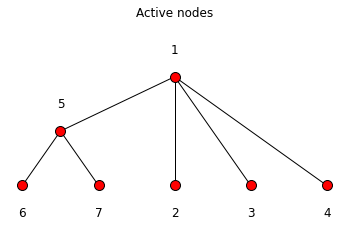

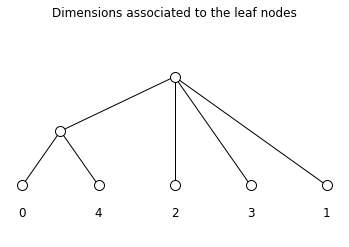

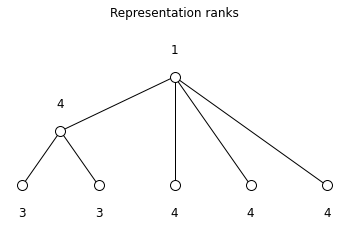

Number of evaluations = 668
Storage = 382
Ranks = [1 4 4 4 4 3 3]
Error = 4.53563e-15


In [16]:
# run again with a random tree
TREE                       = tensap.DimensionTree.random(D, [2, 4])
FPCA.max_rank              = np.random.randint(1, 9, TREE.nb_nodes)
FPCA.max_rank[TREE.root-1] = 1
F, OUTPUT                  = FPCA.tree_based_approximation(FUN, TREE)

# plot tree
F.tensor.plot(title='Active nodes')
F.tensor.tree.plot_dims(title='Dimensions associated to the leaf nodes')
F.tensor.tree.plot_with_labels_at_nodes(F.tensor.representation_rank,
                                        title='Representation ranks')
print('Number of evaluations = %i' % OUTPUT['number_of_evaluations'])
print('Storage = %i' % F.storage())
print('Ranks = %s' % F.tensor.ranks)
X_TEST = X.random(1e3)
F_X_TEST = F(X_TEST)
Y_TEST = FUN(X_TEST)
print('Error = %2.5e' % (np.linalg.norm(Y_TEST - F_X_TEST) /
                         np.linalg.norm(Y_TEST)))